In [53]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
os.listdir('/content/drive/MyDrive')

['Untitled document (20).gdoc',
 'Untitled document (19).gdoc',
 'Untitled document (18).gdoc',
 'Untitled document (17).gdoc',
 'Untitled document (16).gdoc',
 'Untitled document (15).gdoc',
 'Untitled document (14).gdoc',
 'Untitled document (13).gdoc',
 'Untitled document (12).gdoc',
 'Untitled document (11).gdoc',
 'Untitled document (10).gdoc',
 'Untitled document (9).gdoc',
 'Untitled document (8).gdoc',
 'Untitled document (7).gdoc',
 'Untitled document (6).gdoc',
 'Untitled document (5).gdoc',
 'CS23B1021.gdoc',
 'Portfolio.gsite',
 'Project proposal.gdoc',
 'Untitled document - Pie chart 1 (1).gsheet',
 'Untitled document (4).gdoc',
 'Untitled document (3).gdoc',
 'Untitled document - Pie chart 1.gsheet',
 'Untitled document (2).gdoc',
 'imp.gdoc',
 'Untitled document (1).gdoc',
 'cs23b1021-Assignment.gdoc',
 'lab11,1:cs23b1021.gdoc',
 'CS23B1021-lab-12.gdoc',
 'Project-1.gdoc',
 'Untitled document.gdoc',
 'PROJECT REPORT.gslides',
 'Project Report: Image Colorization with PIL

In [56]:
import zipfile

zip_path = "/content/drive/MyDrive/stage1_train.zip"
extract_path = "/content/stage1_train"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped fast to Colab local storage")

✅ Unzipped fast to Colab local storage


In [58]:
import os

base_path = "/content/stage1_train"

image_count = 0
mask_count = 0

for folder in os.listdir(base_path):
    img_path = os.path.join(base_path, folder, "images")
    msk_path = os.path.join(base_path, folder, "masks")

    if os.path.exists(img_path):
        image_count += len(os.listdir(img_path))

    if os.path.exists(msk_path):
        mask_count += len(os.listdir(msk_path))

print("Images:", image_count)
print("Masks :", mask_count)

Images: 670
Masks : 29461


In [59]:
def watershed_with_markers(img):


    clahe = cv2.createCLAHE(2.0, (8,8))
    img_eq = clahe.apply(img)


    _, thresh = cv2.threshold(img_eq, 0, 255, cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)


    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


    sure_bg = cv2.dilate(opening, kernel, iterations=3)


    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)


    ret, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)


    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    pred = (markers > 1).astype(np.uint8)
    return pred

In [60]:
def watershed_without_markers(img):


    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)


    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(thresh, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    pred = (markers > 1).astype(np.uint8)
    return pred

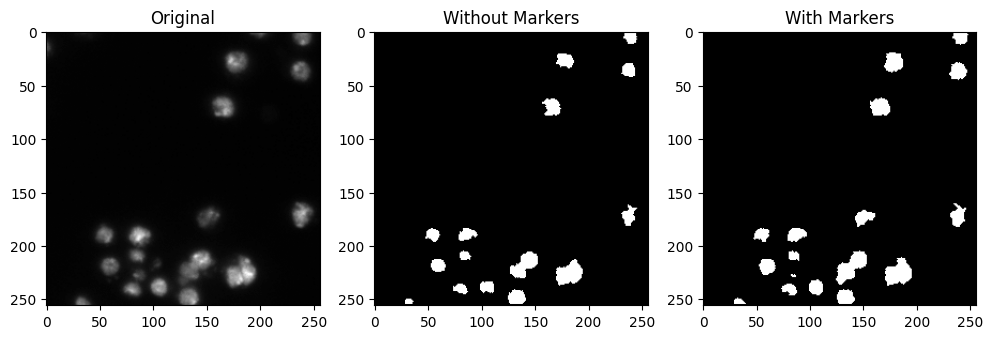

In [61]:

base_path = "/content/stage1_train"
sample_folder = sorted(os.listdir(base_path))[0]


img_dir = os.path.join(base_path, sample_folder, "images")
img_name = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, img_name)

img = cv2.imread(img_path, 0)


p1 = watershed_without_markers(img)
p2 = watershed_with_markers(img)


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(p1, cmap='gray')
plt.title("Without Markers")

plt.subplot(1,3,3)
plt.imshow(p2, cmap='gray')
plt.title("With Markers")

plt.show()

In [62]:
def compute_metrics(gt, pred):
    gt = gt.flatten()
    pred = pred.flatten()

    tn, fp, fn, tp = confusion_matrix(gt, pred, labels=[0,1]).ravel()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    accuracy    = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    dice        = (2 * tp) / (2 * tp + fp + fn + 1e-8)

    return sensitivity, specificity, accuracy, dice

In [63]:
no_marker_results = []
marker_results = []

base_path = "/content/stage1_train"

sample_folders = sorted(os.listdir(base_path))
print("Processing samples:", len(sample_folders))

for folder in sample_folders:

    folder_path = os.path.join(base_path, folder)

    img_dir = os.path.join(folder_path, "images")
    mask_dir = os.path.join(folder_path, "masks")

    if not os.path.exists(img_dir):
        continue


    img_name = os.listdir(img_dir)[0]
    img_path = os.path.join(img_dir, img_name)

    img = cv2.imread(img_path, 0)
    if img is None:
        continue

    gt = np.zeros_like(img, dtype=np.uint8)

    if os.path.exists(mask_dir):
        for m in os.listdir(mask_dir):
            m_path = os.path.join(mask_dir, m)
            m_img = cv2.imread(m_path, 0)
            if m_img is not None:
                gt = np.maximum(gt, (m_img > 0).astype(np.uint8))


    if gt.sum() == 0:
        continue

    pred1 = watershed_without_markers(img)
    no_marker_results.append(compute_metrics(gt, pred1))

    pred2 = watershed_with_markers(img)
    marker_results.append(compute_metrics(gt, pred2))

print("Done ✅ Processed:", len(no_marker_results))

Processing samples: 670
Done ✅ Processed: 670


In [65]:
no_marker_results = np.array(no_marker_results)
marker_results = np.array(marker_results)

results = pd.DataFrame({
    "Metric": ["Sensitivity", "Specificity", "Accuracy", "Dice"],
    "Without Markers": np.mean(no_marker_results, axis=0),
    "With Markers": np.mean(marker_results, axis=0)
})

display(results)

,Metric,Without Markers,With Markers
0,Sensitivity,0.467452,0.622762
1,Specificity,0.848970,0.840639
2,Accuracy,0.798731,0.813141
3,Dice,0.576026,0.687371


The marker-controlled watershed method clearly performs better than the basic watershed. It achieves higher sensitivity, accuracy, and Dice score, indicating more accurate and complete nuclei segmentation while maintaining similar specificity. This shows that using markers helps control over-segmentation and improves object separation. Therefore, the marker-based watershed is the more effective approach for nuclei segmentation on this dataset.
